In [1]:
import pandas as pd
import numpy as np
from dateutil.parser import parse 
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm 
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from datetime import datetime
import time
from scipy.interpolate import interp1d
import statsmodels.api as sm
import itertools
import seaborn as sns
# 设置中文和负号正常显示
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

### 导入数据

In [2]:
df = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)
df

,日期,DATA_DT,内存负载,主机CPU平均负载
0,2020-03-01 01:00:00,1582995600,81.8242,2.8333
1,2020-03-01 02:00:00,1582999200,81.8145,3.1818
2,2020-03-01 03:00:00,1583002800,81.8092,3.0833
3,2020-03-01 04:00:00,1583006400,81.8042,3.0833
4,2020-03-01 05:00:00,1583010000,81.8333,2.5000
...,...,...,...,...
2202,2020-05-31 19:00:00,1590922800,70.6183,2.0000
2203,2020-05-31 20:00:00,1590926400,70.5208,1.9167
2204,2020-05-31 21:00:00,1590930000,70.5608,1.7500
2205,2020-05-31 22:00:00,1590933600,70.5292,2.0000


In [3]:
df["内存负载"].isnull().any()

True

In [4]:
df.loc[174]

日期           2020-03-08 07:00:00
DATA_DT               1583622000
内存负载                     81.9075
主机CPU平均负载                 3.9167
Name: 174, dtype: object

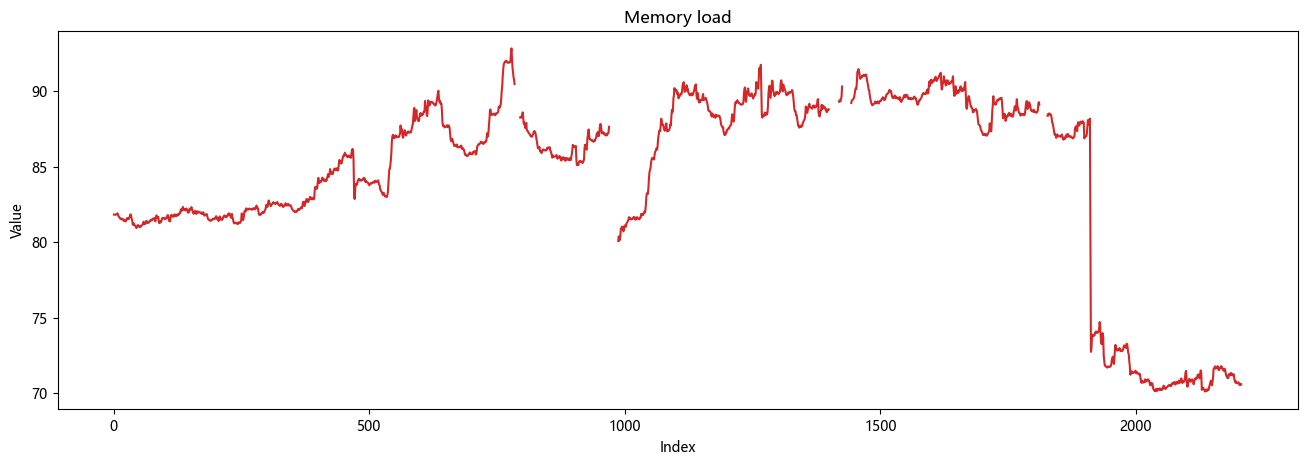

In [5]:
# Draw Plot-----绘图函数
def plot_df(df, x, y, title="", xlabel='Index', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(df, x=df.index, y= df["内存负载"], title='Memory load')

### 缺失值填充

In [6]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out
# 使用k-近邻法填补缺失值
df["内存负载"] = knn_mean(df["内存负载"], 24)

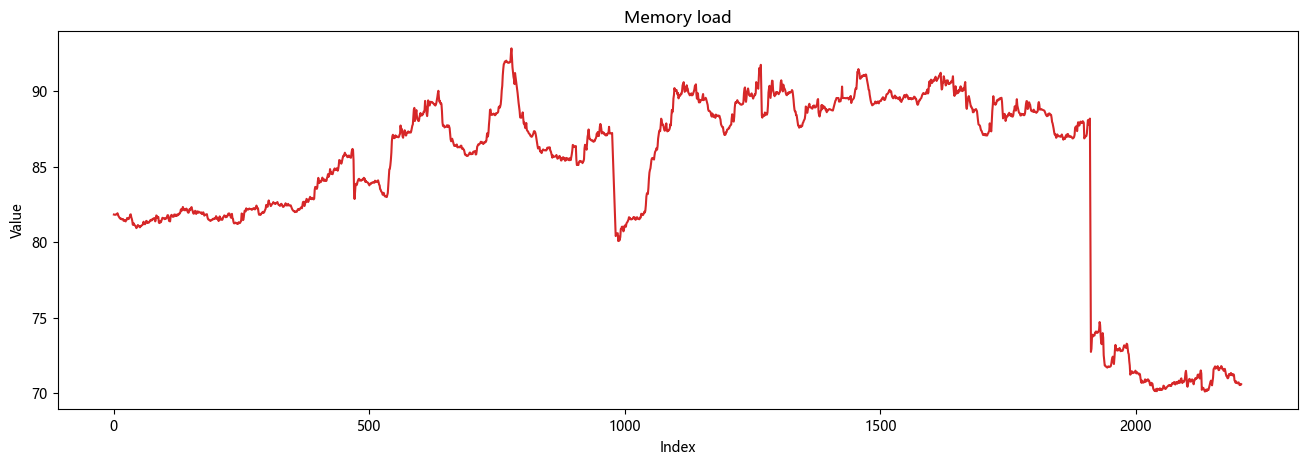

In [7]:
plot_df(df, x=df.index, y= df["内存负载"], title='Memory load')

In [8]:
df.loc[2201]

日期           2020-05-31 18:00:00
DATA_DT               1590919200
内存负载                     70.7008
主机CPU平均负载                 1.8333
Name: 2201, dtype: object

### 去除季节性因素

In [9]:
temp_Series =df["内存负载"]

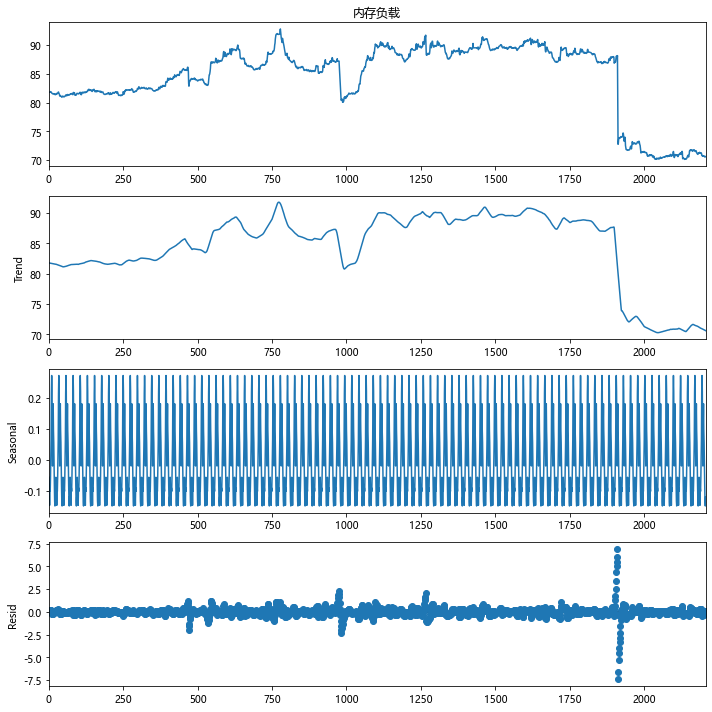

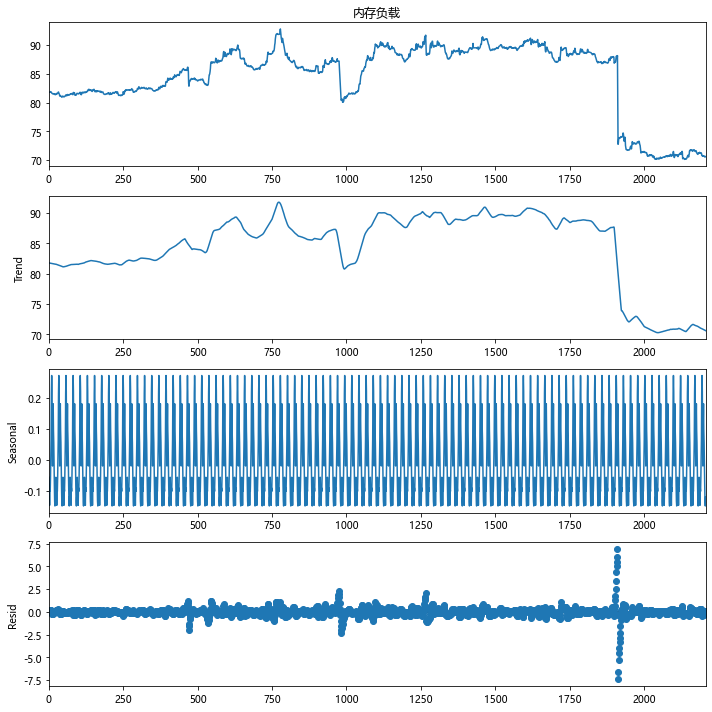

In [10]:
plt.rcParams.update({'figure.figsize': (10,10)})
result_add = sm.tsa.seasonal_decompose(temp_Series, model='additive',period = 24, extrapolate_trend='freq')
result_add.plot()

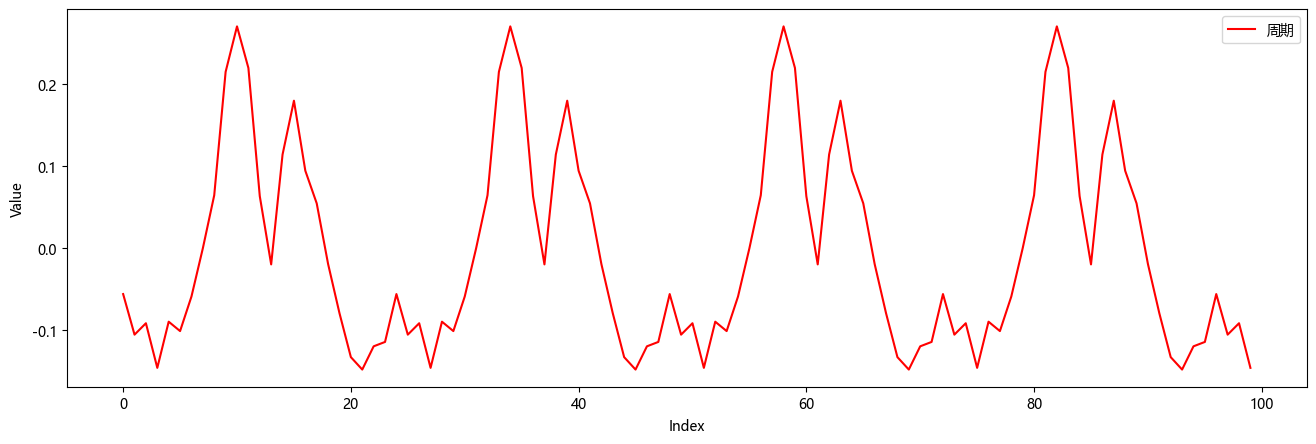

In [11]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot((result_add.seasonal)[0:100],label = '周期', color = 'red')
# plt.plot((result_add.trend)[0:100],label = '趋势', color = 'black')
# plt.plot((result_add.resid)[0:100],label = '随机', color = 'black')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend(loc='best')

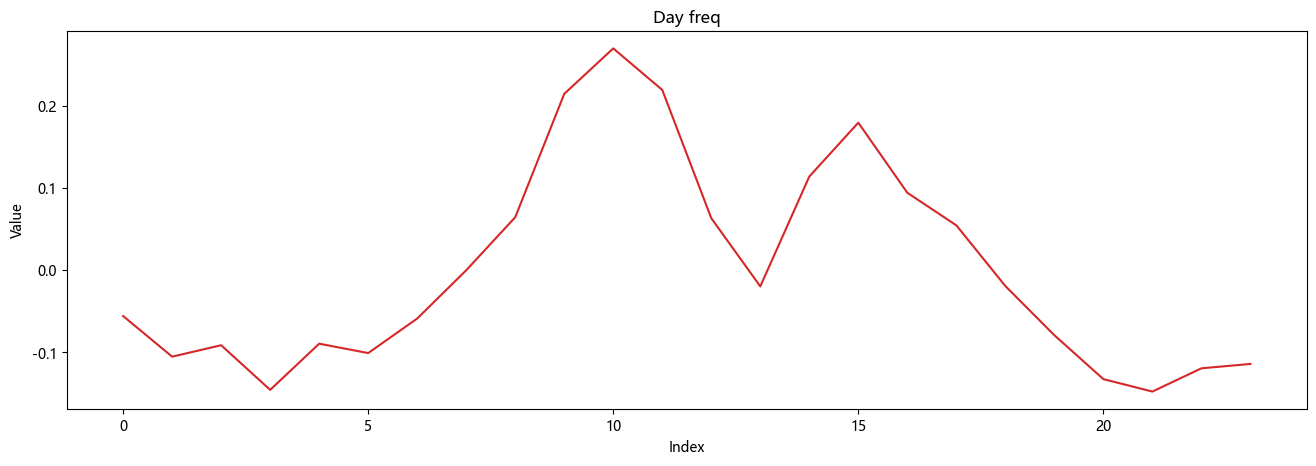

[-0.05566,
 -0.105116,
 -0.091199,
 -0.145571,
 -0.089326,
 -0.100757,
 -0.058671,
 0.000122,
 0.064746,
 0.215038,
 0.270441,
 0.219774,
 0.063583,
 -0.019519,
 0.114323,
 0.179914,
 0.094565,
 0.054839,
 -0.019065,
 -0.079007,
 -0.132503,
 -0.14764,
 -0.119328,
 -0.113983]

In [12]:
# 周期值24
a = result_add.seasonal
season = []
for i in range(24):
    season.append(float(format(a[i], '.6f')))
plot_df(season, x=range(24), y= season, title='Day freq')
season

In [13]:
arr = temp_Series - result_add.seasonal
arr

0       81.879860
1       81.919616
2       81.900399
3       81.949771
4       81.922626
          ...    
2202    70.637365
2203    70.599807
2204    70.693303
2205    70.676840
2206    70.699328
Length: 2207, dtype: float64

### 准备数据

In [14]:
train = arr[0:2046]
test = arr[2046:]
train

0       81.879860
1       81.919616
2       81.900399
3       81.949771
4       81.922626
          ...    
2041    70.219316
2042    70.371199
2043    70.375571
2044    70.323526
2045    70.317457
Length: 2046, dtype: float64

In [15]:
adftrain = ts.adfuller(train)
adftrain

(-0.791354363928442,
 0.8216484753884293,
 3,
 2042,
 {'1%': -3.433556434584693,
  '5%': -2.862956446160557,
  '10%': -2.5675240526993854},
 467.2153618176485)

### 9.预测

In [16]:
model = sm.tsa.ARIMA(train, order=(0, 1, 2))
result = model.fit()

In [17]:
te = result.predict(start=1,end=2039, dynamic=False, typ='levels')
len(te.values)

2039

In [18]:
num = 12
result = model.fit()
foreca = result.forecast(num)
test_Y = foreca[0]
test_Y

array([70.31280789, 70.30721427, 70.3015807 , 70.29594713, 70.29031357,
       70.28468   , 70.27904643, 70.27341286, 70.26777929, 70.26214573,
       70.25651216, 70.25087859])

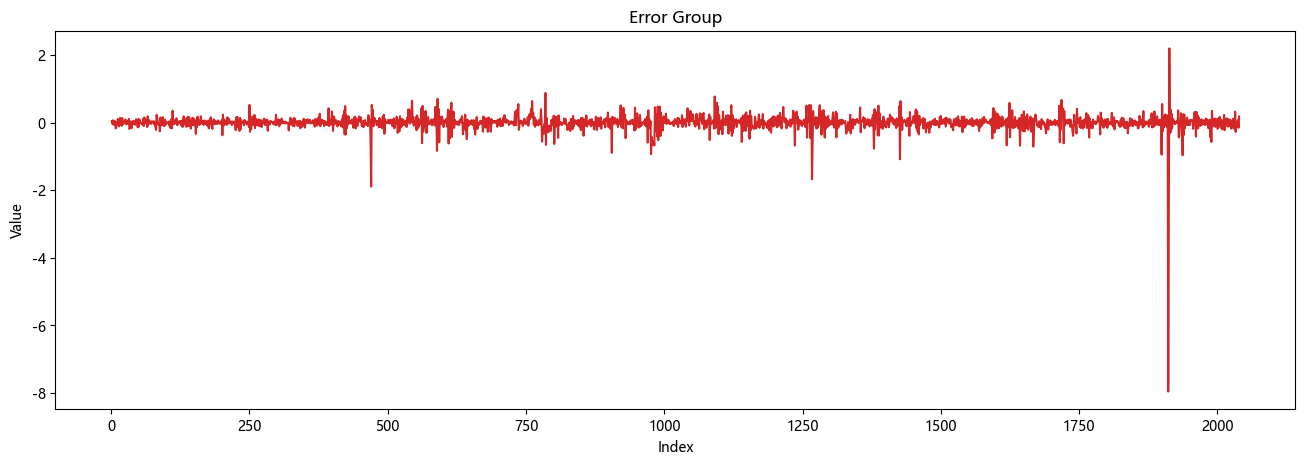

In [19]:
arr1 = train[1:2040] - te.values
error = pd.Series(arr1,index=te.index)
plot_df(error, x=error.index, y= error.values, title='Error Group')

In [20]:
from scipy.interpolate import UnivariateSpline
from numpy import linspace,exp
from numpy.random import randn
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
error

1       0.045389
2      -0.033084
3       0.071377
4      -0.059297
5       0.049489
          ...   
2035    0.005526
2036   -0.005833
2037    0.074634
2038   -0.150794
2039    0.180173
Length: 2039, dtype: float64

In [21]:
error_temp = pd.DataFrame(error)
des = error_temp.describe()
U = des.iloc[6]
L = des.iloc[4]
IQR = U-L
top = U+1.5*IQR
bottom = L-1.5*IQR
des

,0
count,2039.000000
mean,0.000014
std,0.270406
min,-7.956998
25%,-0.069766
50%,0.007307
75%,0.088974
max,2.198722


In [22]:
for i in range(len(error)):
    if (error.iloc[i] > top).bool():
        error.iloc[i] = np.nan
    if (error.iloc[i] < bottom).bool():
        error.iloc[i] = np.nan

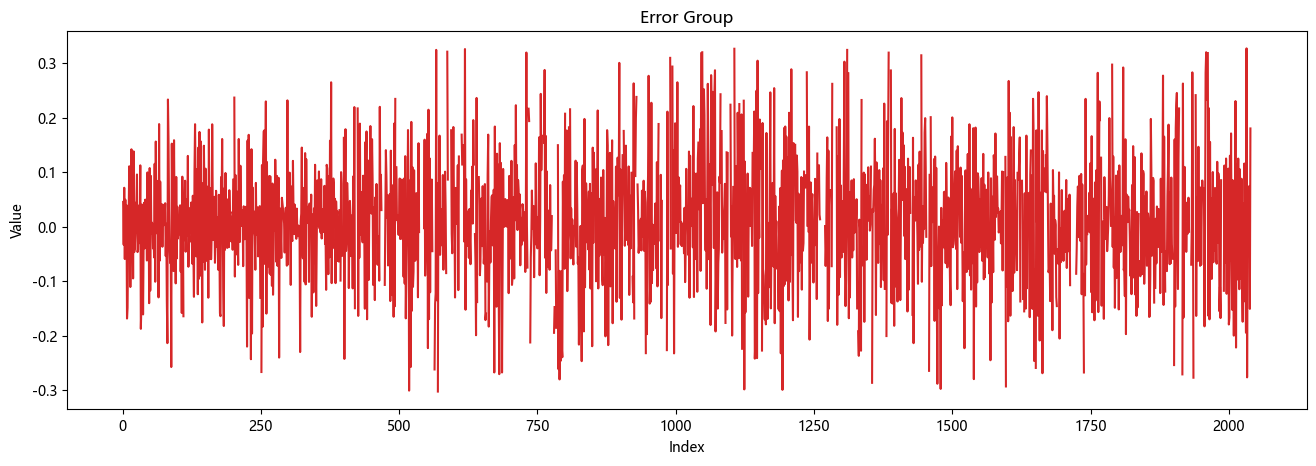

In [23]:
plot_df(error, x=error.index, y= error.values, title='Error Group')

In [24]:
error_temp2 = pd.DataFrame(error)
error_temp2.columns = ["value"]
print(f"缺失率为:{(100-(error_temp2.count()/(len(error))*100)).item()}%")

缺失率为:8.092202059833255%


In [25]:
error_temp2["value"] = knn_mean(error_temp2["value"], 9)

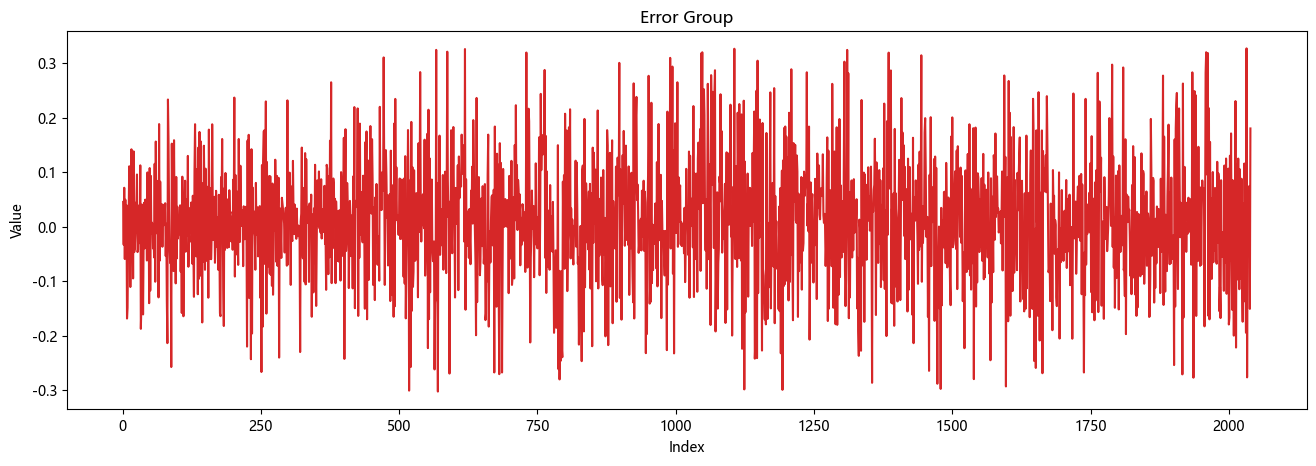

In [26]:
plot_df(error_temp2["value"], x=error_temp2["value"].index, y= error_temp2["value"].values, title='Error Group')

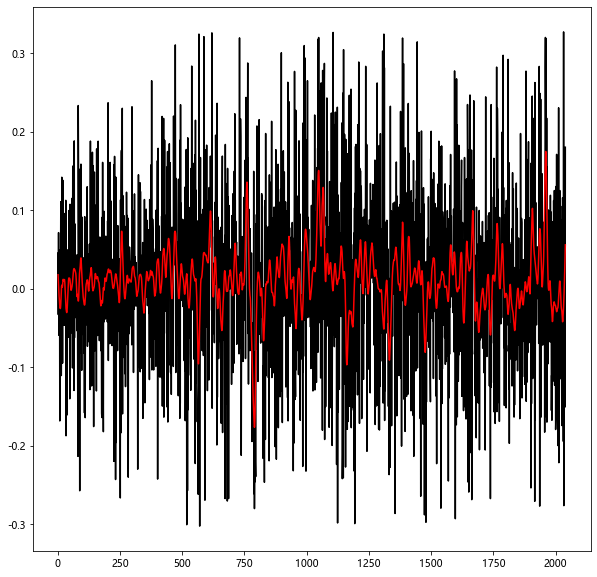

In [27]:
# Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(error_temp2["value"], np.arange(len(error_temp2["value"])), frac=0.008)[:, 1], index=error.index, columns=['value'])
# df_loess_15 = pd.DataFrame(lowess(df_orig.value, np.arange(len(df_orig.value)), frac=0.15)[:, 1], index=df_orig.index, columns=['value'])
plt.plot(error,color = 'black')
plt.plot(df_loess_5,label = '拟合曲线',color = 'red')

In [28]:
# 索引185指18点
truth = df_loess_5["value"].loc[168:2040]

In [29]:
# 每天的7点到18点的内存负载数据
# label矩阵 从第8天算共78天的误差数据,索引168:2039
label = [] 
for i in range(78):
    arr = truth.loc[174+i*24:185+i*24].values
    label.append(arr)
# len(label) # 维度 78*12

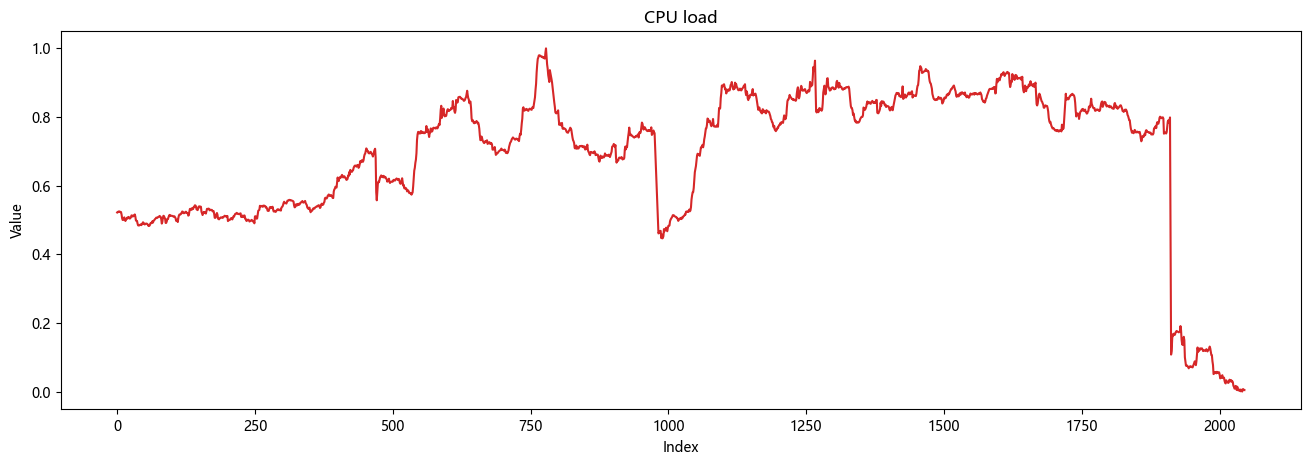

In [30]:
max_value = train.max(axis=0, skipna=True)
min_value = train.min(axis=0, skipna=True)
scalar = max_value - min_value
for i in range(len(train)):
    train[i]=(train[i]-min_value)/scalar
plot_df(df, x=df.index[0:2046], y= train, title='CPU load')

In [31]:
LSTM_input = []
for i in range(78):
    arr = train.loc[6+i*24:173+i*24]
    LSTM_input.append(arr.values)
ma = pd.DataFrame(LSTM_input)
ma

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,0.522865,0.523139,0.516259,0.505282,0.500095,0.499959,0.505123,0.507535,0.502405,0.497044,...,0.532283,0.531246,0.533300,0.531418,0.528025,0.529791,0.529468,0.529140,0.529120,0.525268
1,0.512756,0.512067,0.516147,0.510227,0.499119,0.497015,0.497394,0.489858,0.484204,0.484961,...,0.507557,0.506780,0.507044,0.508223,0.506691,0.508524,0.510784,0.512322,0.511559,0.510388
2,0.489373,0.487453,0.485541,0.482346,0.485859,0.483848,0.488229,0.491510,0.490769,0.491902,...,0.509499,0.513569,0.517372,0.518037,0.519186,0.520840,0.518016,0.517692,0.518084,0.516729
3,0.510147,0.508858,0.502574,0.489431,0.494264,0.506748,0.512207,0.511116,0.506916,0.503784,...,0.499166,0.500739,0.500814,0.499608,0.495392,0.496786,0.497770,0.498408,0.500366,0.498569
4,0.509923,0.509270,0.510728,0.507743,0.505152,0.497538,0.497515,0.500711,0.493938,0.505547,...,0.539595,0.540980,0.540160,0.539107,0.538394,0.541838,0.539984,0.541858,0.539825,0.539812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.814350,0.809853,0.810989,0.816086,0.817970,0.830643,0.830284,0.828297,0.839166,0.853312,...,0.163453,0.168717,0.167150,0.165645,0.171537,0.174494,0.176596,0.175373,0.174310,0.173627
74,0.817407,0.819810,0.829896,0.838650,0.843779,0.845299,0.829617,0.834191,0.839201,0.844098,...,0.077117,0.075073,0.073430,0.072000,0.067712,0.072423,0.073178,0.073750,0.071345,0.072599
75,0.825350,0.824026,0.824043,0.837420,0.840758,0.835615,0.827822,0.831565,0.826286,0.824020,...,0.125485,0.122770,0.125531,0.125515,0.125890,0.122545,0.118042,0.121111,0.120348,0.119741
76,0.821810,0.819032,0.814421,0.805941,0.802866,0.796483,0.790978,0.790705,0.776848,0.766081,...,0.077376,0.050943,0.052361,0.054807,0.057043,0.056459,0.053116,0.057527,0.054786,0.055369


### 神经网络训练误差数据

In [32]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [33]:
train_X = torch.Tensor(np.array(LSTM_input).reshape(-1, 7, 24))
train_Y = torch.Tensor(np.array(label).reshape(-1, 1, 12))
train_X.shape

torch.Size([78, 7, 24])

In [34]:
test_X = torch.Tensor(np.array(train.loc[1878:2045]).reshape(-1, 7, 24))
test_X.shape

torch.Size([1, 7, 24])

In [35]:
class lstm(nn.Module):
    def __init__(self,input_size=16,hidden_size=100,output_size=1,num_layer=2):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer,batch_first=True)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
        x = x[:,[6],:]
        b, s, h = x.size()
        x = x.view(-1,h)
        x = self.layer2(x)
        x = x.view(b, s, -1)
        return x

model = lstm(24, 128, 12, 2)
model

lstm(
  (layer1): LSTM(24, 128, num_layers=2, batch_first=True)
  (layer2): Linear(in_features=128, out_features=12, bias=True)
)

In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epoch_n = 5000
# # 初始化 early_stopping 对象
# # 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
# patience = 20  

# # 关于 EarlyStopping 的代码可先看博客后面的内容
# early_stopping = EarlyStopping(patience, verbose=True)

In [37]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(epoch_n):
    var_x = Variable(train_X)
    var_y = Variable(train_Y)
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 5 == 0: # 每 2 次输出结果
        print('Epoch: {}, Loss: {:.8f}'.format(e + 1, loss.item()))
    ep.append(e+1)
    losses.append(loss.item())
#     break
    if (e+1)%500 == 0:
        for p in optimizer.param_groups:
            p['lr'] *= 0.1
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

print('Finished Training') 

Epoch: 5, Loss: 0.00577750
Epoch: 10, Loss: 0.00340258
Epoch: 15, Loss: 0.00275373
Epoch: 20, Loss: 0.00203889
Epoch: 25, Loss: 0.00201256
Epoch: 30, Loss: 0.00181272
Epoch: 35, Loss: 0.00180807
Epoch: 40, Loss: 0.00174126
Epoch: 45, Loss: 0.00171585
Epoch: 50, Loss: 0.00168593
Epoch: 55, Loss: 0.00165295
Epoch: 60, Loss: 0.00162480
Epoch: 65, Loss: 0.00159212
Epoch: 70, Loss: 0.00156459
Epoch: 75, Loss: 0.00154281
Epoch: 80, Loss: 0.00152569
Epoch: 85, Loss: 0.00151178
Epoch: 90, Loss: 0.00149954
Epoch: 95, Loss: 0.00148807
Epoch: 100, Loss: 0.00147621
Epoch: 105, Loss: 0.00146413
Epoch: 110, Loss: 0.00145247
Epoch: 115, Loss: 0.00146585
Epoch: 120, Loss: 0.00145551
Epoch: 125, Loss: 0.00143715
Epoch: 130, Loss: 0.00142154
Epoch: 135, Loss: 0.00140723
Epoch: 140, Loss: 0.00139386
Epoch: 145, Loss: 0.00138094
Epoch: 150, Loss: 0.00136696
Epoch: 155, Loss: 0.00135142
Epoch: 160, Loss: 0.00133408
Epoch: 165, Loss: 0.00131641
Epoch: 170, Loss: 0.00130019
Epoch: 175, Loss: 0.00136244
Epoch

Epoch: 1410, Loss: 0.00010320
Epoch: 1415, Loss: 0.00010304
Epoch: 1420, Loss: 0.00010289
Epoch: 1425, Loss: 0.00010273
Epoch: 1430, Loss: 0.00010258
Epoch: 1435, Loss: 0.00010242
Epoch: 1440, Loss: 0.00010227
Epoch: 1445, Loss: 0.00010211
Epoch: 1450, Loss: 0.00010196
Epoch: 1455, Loss: 0.00010180
Epoch: 1460, Loss: 0.00010165
Epoch: 1465, Loss: 0.00010149
Epoch: 1470, Loss: 0.00010133
Epoch: 1475, Loss: 0.00010118
Epoch: 1480, Loss: 0.00010102
Epoch: 1485, Loss: 0.00010086
Epoch: 1490, Loss: 0.00010071
Epoch: 1495, Loss: 0.00010055
Epoch: 1500, Loss: 0.00010039
Epoch: 1505, Loss: 0.00010035
Epoch: 1510, Loss: 0.00010033
Epoch: 1515, Loss: 0.00010032
Epoch: 1520, Loss: 0.00010030
Epoch: 1525, Loss: 0.00010029
Epoch: 1530, Loss: 0.00010027
Epoch: 1535, Loss: 0.00010025
Epoch: 1540, Loss: 0.00010024
Epoch: 1545, Loss: 0.00010022
Epoch: 1550, Loss: 0.00010020
Epoch: 1555, Loss: 0.00010019
Epoch: 1560, Loss: 0.00010017
Epoch: 1565, Loss: 0.00010016
Epoch: 1570, Loss: 0.00010014
Epoch: 157

Epoch: 2780, Loss: 0.00009834
Epoch: 2785, Loss: 0.00009834
Epoch: 2790, Loss: 0.00009834
Epoch: 2795, Loss: 0.00009834
Epoch: 2800, Loss: 0.00009834
Epoch: 2805, Loss: 0.00009834
Epoch: 2810, Loss: 0.00009834
Epoch: 2815, Loss: 0.00009834
Epoch: 2820, Loss: 0.00009834
Epoch: 2825, Loss: 0.00009834
Epoch: 2830, Loss: 0.00009834
Epoch: 2835, Loss: 0.00009834
Epoch: 2840, Loss: 0.00009834
Epoch: 2845, Loss: 0.00009834
Epoch: 2850, Loss: 0.00009834
Epoch: 2855, Loss: 0.00009834
Epoch: 2860, Loss: 0.00009834
Epoch: 2865, Loss: 0.00009834
Epoch: 2870, Loss: 0.00009834
Epoch: 2875, Loss: 0.00009834
Epoch: 2880, Loss: 0.00009834
Epoch: 2885, Loss: 0.00009834
Epoch: 2890, Loss: 0.00009834
Epoch: 2895, Loss: 0.00009834
Epoch: 2900, Loss: 0.00009834
Epoch: 2905, Loss: 0.00009834
Epoch: 2910, Loss: 0.00009833
Epoch: 2915, Loss: 0.00009833
Epoch: 2920, Loss: 0.00009833
Epoch: 2925, Loss: 0.00009833
Epoch: 2930, Loss: 0.00009833
Epoch: 2935, Loss: 0.00009833
Epoch: 2940, Loss: 0.00009833
Epoch: 294

Epoch: 4150, Loss: 0.00009833
Epoch: 4155, Loss: 0.00009833
Epoch: 4160, Loss: 0.00009833
Epoch: 4165, Loss: 0.00009833
Epoch: 4170, Loss: 0.00009833
Epoch: 4175, Loss: 0.00009833
Epoch: 4180, Loss: 0.00009833
Epoch: 4185, Loss: 0.00009833
Epoch: 4190, Loss: 0.00009833
Epoch: 4195, Loss: 0.00009833
Epoch: 4200, Loss: 0.00009833
Epoch: 4205, Loss: 0.00009833
Epoch: 4210, Loss: 0.00009833
Epoch: 4215, Loss: 0.00009833
Epoch: 4220, Loss: 0.00009833
Epoch: 4225, Loss: 0.00009833
Epoch: 4230, Loss: 0.00009833
Epoch: 4235, Loss: 0.00009833
Epoch: 4240, Loss: 0.00009833
Epoch: 4245, Loss: 0.00009833
Epoch: 4250, Loss: 0.00009833
Epoch: 4255, Loss: 0.00009833
Epoch: 4260, Loss: 0.00009833
Epoch: 4265, Loss: 0.00009833
Epoch: 4270, Loss: 0.00009833
Epoch: 4275, Loss: 0.00009833
Epoch: 4280, Loss: 0.00009833
Epoch: 4285, Loss: 0.00009833
Epoch: 4290, Loss: 0.00009833
Epoch: 4295, Loss: 0.00009833
Epoch: 4300, Loss: 0.00009833
Epoch: 4305, Loss: 0.00009833
Epoch: 4310, Loss: 0.00009833
Epoch: 431

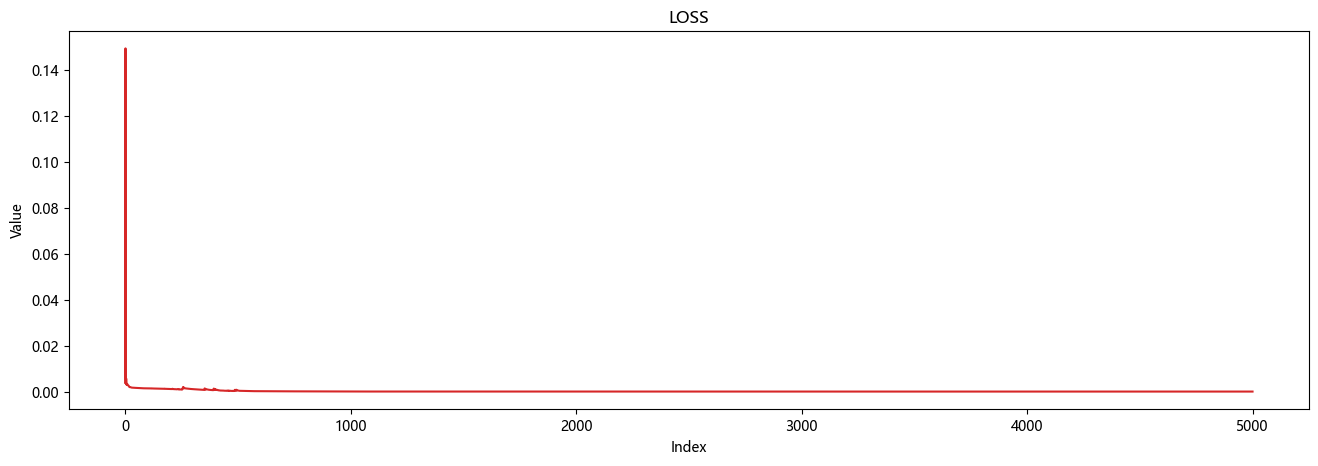

In [38]:
# plot_df(df, x=range(epoch_n), y= lr_list, title='LOSS')
plot_df(df, x=ep, y= losses, title='LOSS')

### 检验神经网络模型效果

In [39]:
torch.save(model, 'error_net.pkl')
model2 = torch.load('error_net.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [40]:
foreca_val = test_Y+result_add.seasonal[6:num+6]
# 加上周期值
top = []
bottom = []
for data in foreca[2]:
    top.append(data[1])
    bottom.append(data[0])
top = top + result_add.seasonal[6:num+6]
bottom = bottom + result_add.seasonal[6:num+6]

In [41]:
MSE = 0
error = []
for i in range(num):
    err =  df["内存负载"].loc[2046+i] - foreca_val[6+i]
    error.append(err)
    MSE += (err)**2
MSE

0.3149229456785877

In [42]:
error

[-0.06163730216134411,
 0.00016395295655513564,
 -0.15632622916874084,
 -0.29178489161353127,
 -0.2907544402102218,
 -0.2994539195133399,
 -0.10432983371870819,
 0.0728056824368366,
 0.0986981686422439,
 0.010440164129136065,
 0.021423033494556876,
 -0.029017253195917192]

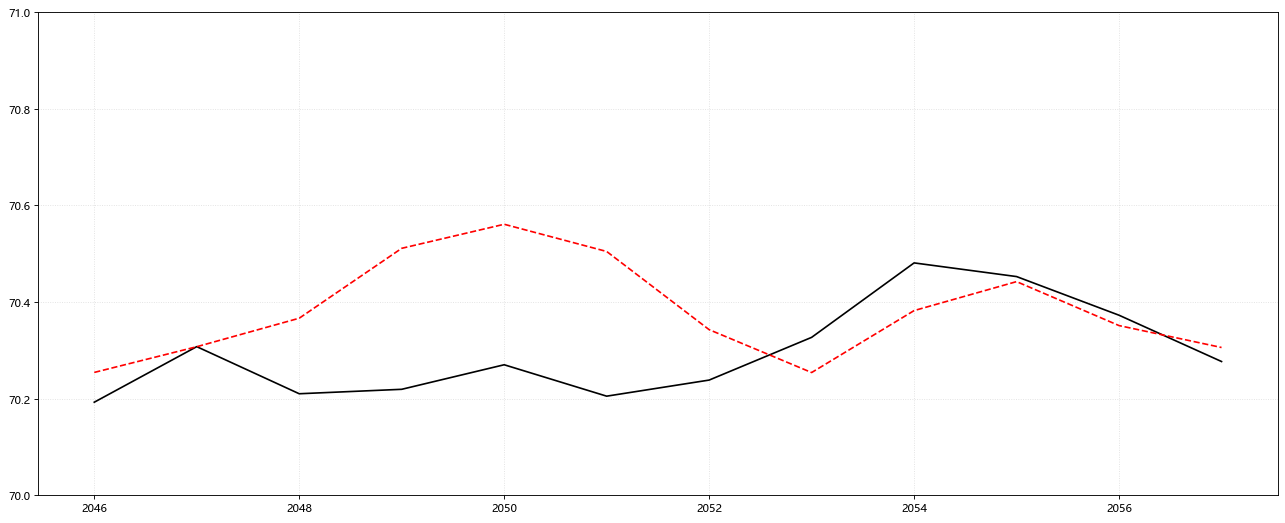

In [43]:
plt.figure(figsize=(20,8),dpi=80)
test_temp = df["内存负载"][len(train):len(train)+num]
# color可以百度颜色代码
plt.plot(test_temp.index,test_temp,label="truth",color="black")
plt.plot(test_temp.index,foreca_val,label="predict",color="red",linestyle="--")
# plt.fill_between(test_temp.index,top,bottom,color='blue',alpha=0.05)
#绘制网格
plt.grid(alpha=0.4,linestyle=':')
plt.ylim(70,71)
#展示
plt.show()

In [44]:
outputs = model2(torch.Tensor(np.array(test_X).reshape(-1, 7, 24)))
error_list = outputs.detach().numpy().tolist()
error_list[0][0]

[-0.07606580853462219,
 0.0153878852725029,
 -0.06858347356319427,
 -0.06927638500928879,
 -0.07779628783464432,
 -0.08386193960905075,
 -0.09584566950798035,
 -0.008121572434902191,
 -0.10780531167984009,
 -0.012957043945789337,
 -0.01364346593618393,
 -0.10801603645086288]

In [45]:
prdict = foreca_val.values + error_list[0][0]
prdict

array([70.17807149, 70.32272393, 70.29774276, 70.44170851, 70.48295815,
       70.42059198, 70.24678416, 70.24577275, 70.27429652, 70.42910279,
       70.3374335 , 70.19770122])

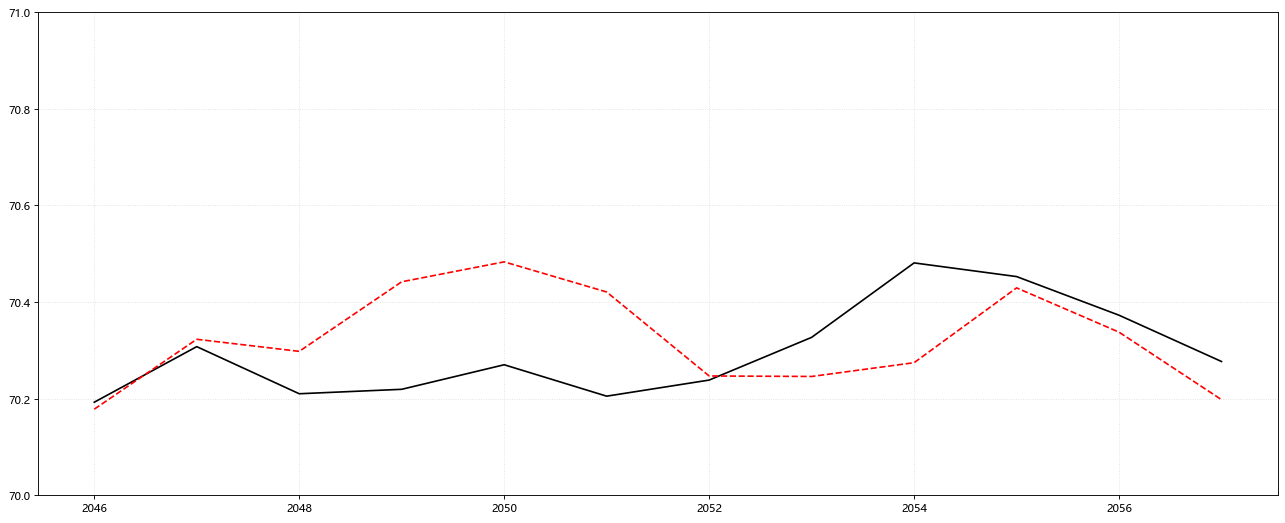

In [46]:
plt.figure(figsize=(20,8),dpi=80)
test_temp = df["内存负载"][len(train):len(train)+num]
plt.plot(test_temp.index,test_temp,label="truth",color="black")
plt.plot(test_temp.index,prdict,label="predict",color="red",linestyle="--")
plt.grid(alpha=0.4,linestyle=':')

plt.ylim(70,71)
#展示
plt.show()

In [47]:
MSE = 0
errors = []
for i in range(num):
    err =  df["内存负载"].loc[2046+i] - prdict[i]
    errors.append(err)
    MSE += (err)**2
MSE

0.20676263853845295

In [48]:
errors

[0.014428506373278083,
 -0.015223932315947764,
 -0.08774275560554656,
 -0.22250850660424248,
 -0.21295815237557747,
 -0.21559197990428913,
 -0.00848416421072784,
 0.0809272548717388,
 0.206503480322084,
 0.023397208074925402,
 0.035066499430740805,
 0.07899878325494569]

### 差分

In [49]:
# # # 差分法生成序列
# dif = []
# dif = train.diff(1)

### ADF检验

In [50]:
# timeSeries = dif[1:]
# adftest = ts.adfuller(timeSeries)
# adftest

### ACF和PACF观察

In [51]:
# plot_acf(timeSeries).show()

In [52]:
# plot_pacf(timeSeries).show()

### BIC和AIC定阶

In [53]:
# p_min = 0
# q_min = 0
# p_max = 5
# q_max = 6
# d_min = 0
# d_max = 1

In [54]:
# results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
#                            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
# results_bic

In [55]:
# num = 1
# for p,d,q in itertools.product(range(p_min,p_max+1),
#                                range(d_min,d_max+1),
#                                range(q_min,q_max+1)):
#     if p==0 and d==0 and q==0:
#         results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
#         continue
 
#     try:
#         model = sm.tsa.ARIMA(timeSeries, order=(p, d, q),
# #                                enforce_stationarity=False,
# #                                enforce_invertibility=False,
#                               )
#         results = model.fit()
#         num += 1
#         print(f"循环{num}次")
#         results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
#     except:
#         continue
# results_bic = results_bic[results_bic.columns].astype(float)
# fig, ax = plt.subplots(figsize=(10, 8))
# ax = sns.heatmap(results_bic,
#                  mask=results_bic.isnull(),
#                  ax=ax,
#                  annot=True,
#                  fmt='.2f',
#                  )
# ax.set_title('BIC')

### 验证模型

In [56]:
# from statsmodels.graphics.api import qqplot
# from statsmodels.stats.stattools import durbin_watson #DW检验
# #残差
# model = sm.tsa.ARIMA(timeSeries, order=(0, 1, 2))
# results = model.fit()
# resid = results.resid 
# #利用QQ图检验残差是否满足正态分布
# plt.figure(figsize=(12,8))
# qqplot(resid,line='q',fit=True)
# #利用D-W检验,检验残差的自相关性
# print('D-W检验值为{}'.format(durbin_watson(resid.values)))
# # 当D-W检验值接近于2时，不存在自相关性，说明模型较好。
# # https://wenku.baidu.com/view/57224dcfcf84b9d528ea7aba.html

### 绘制对比图

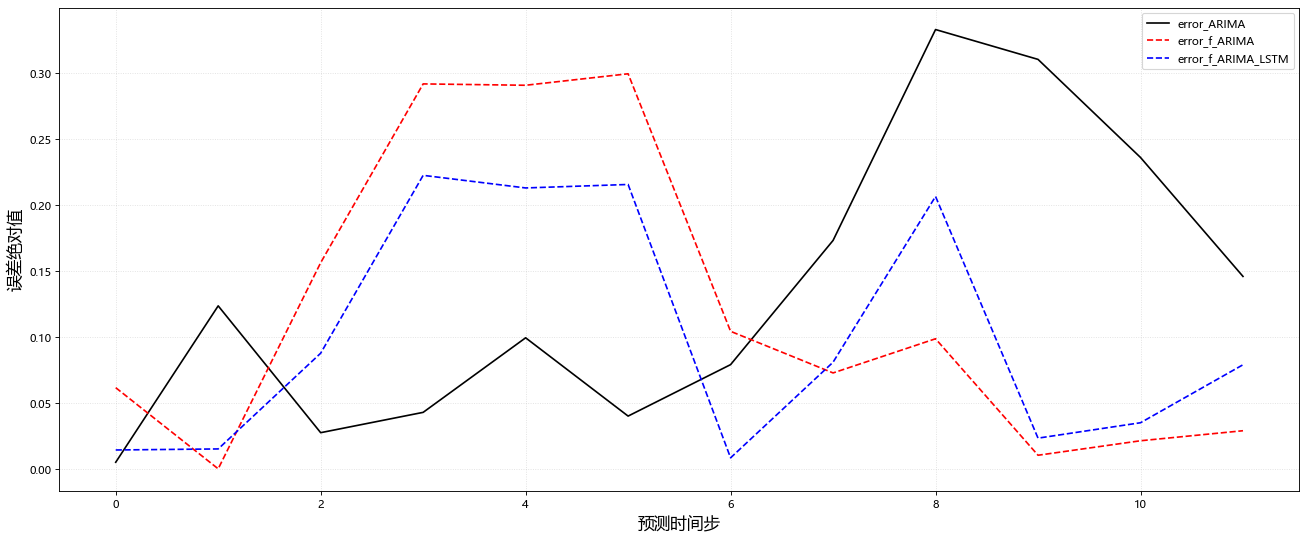

In [67]:
a1 = [-0.0051311868503631786,
 0.12361977310621342,
 0.0275387370117528,
 0.042940150495439866,
 0.09942670094049788,
 0.040113251385562876,
 0.0790998018306226,
 0.17318635227569246,
 0.33297290272075486,
 0.31035945316581603,
 0.23604600361088046,
 0.14593255405594618]
a2 = [-0.06163730216134411,
 0.00016395295655513564,
 -0.15632622916874084,
 -0.29178489161353127,
 -0.2907544402102218,
 -0.2994539195133399,
 -0.10432983371870819,
 0.0728056824368366,
 0.0986981686422439,
 0.010440164129136065,
 0.021423033494556876,
 -0.029017253195917192]
a3 = [0.014428506373278083,
 -0.015223932315947764,
 -0.08774275560554656,
 -0.22250850660424248,
 -0.21295815237557747,
 -0.21559197990428913,
 -0.00848416421072784,
 0.0809272548717388,
 0.206503480322084,
 0.023397208074925402,
 0.035066499430740805,
 0.07899878325494569]

for i in range(len(a3)):
    a1[i] = abs(a1[i])
    a2[i] = abs(a2[i])
    a3[i] = abs(a3[i])

x = range(12)
 
#设置图形大小
plt.figure(figsize=(20,8),dpi=80)
# color可以百度颜色代码
plt.plot(x,a1,label="error_ARIMA",color="black")
plt.plot(x,a2,label="error_f_ARIMA",color="red",linestyle="--")
plt.plot(x,a3,label="error_f_ARIMA_LSTM",color="blue",linestyle="--")
# plt.gca().set(title="", xlabel="", ylabel="",fontdict={'weight': 'normal', 'size': 14})
plt.xlabel('预测时间步', fontdict={'weight': 'normal', 'size': 15})
plt.ylabel('误差绝对值', fontdict={'weight': 'normal', 'size': 15})
#绘制网格
plt.grid(alpha=0.4,linestyle=':')
plt.legend(loc='upper right')
#展示
plt.show()